# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
import pickle
import ast

from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import roc_auc_score
from hyperopt import hp
import lightgbm as lgb
from skopt import BayesSearchCV

sys.path += ['./ilikeds']
import eda 
import helper_functions as h
import train_classifier as t

import warnings                             
warnings.filterwarnings('ignore')
# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [ ]:
# load in the data
# azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
# customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

azdias = pd.read_pickle ('../data/azdias.p')    
customers = pd.read_pickle ('../data/customers.p')    

sampling_rate = 0.01
r=np.random.randint(0, azdias.shape[0], int(azdias.shape[0]*sampling_rate))
azdias=azdias.loc[r,:].copy()
r=np.random.randint(0, customers.shape[0], int(customers.shape[0]*sampling_rate))
customers=customers.loc[r,:].copy()

In [ ]:
# read in feature info file
feat_info = pd.read_csv('./feats_info.csv', sep=';', names=['feat', 'type', 'unknow'])
feat_info.set_index('feat', inplace =True)
feat_info

In [ ]:
# create  a EDA  instance for Azdias.
eda_azdias= eda.EDA(azdias, feat_info, label = 'Azdias')

# create  a EDA  instance for Azdias. for  customers
eda_customers= eda.EDA(customers, feat_info, label = 'Customers')

In [ ]:
type(feat_info.type)

In [ ]:
mixed = eda_azdias.feat_info[ (eda_azdias.feat_info.type == 'mixed') & (eda_azdias.feat_info.is_drop == 0)]
mixed

### Data Preprocessing

In [ ]:
####  Define action dictionary 
# action_dic ={
#     1:  'drop: high missing values',
#     2:  'drop: duplicated',
#     3:  're-encoding: mapping',    
#     4:  're-encoding: logarithmic scaling',        
#     5:  'split',
# }

In [ ]:
# Removing the three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP') in Customers
feats_customers_excl  = list(set(eda_customers.data.columns) - set(eda_azdias.data.columns))
feats_customers_excl
eda_customers.data.drop(columns = feats_customers_excl, inplace =True)

####  Step 1:  Converting of missing and unknown data to NaN

In [ ]:
eda_azdias.missing2nan()
eda_customers.missing2nan()

# Re-Collecting feature stats
eda_azdias.update_stats()
eda_customers.update_stats()

####  Step 2: Remove rows and columns with high miss values

##### a. Deleting rows

In [ ]:
rows_n_nans = azdias.isnull().sum(axis=1)
plt.hist(rows_n_nans / azdias.shape[1], bins=90)

In [ ]:
_, rows_droped = h.split_dataset(azdias, threshold=0.25)
n_deleted_rows = rows_droped.shape[0]
print(f'Before delete the missing rows, {eda_azdias} has {eda_azdias.data.shape[0]} rows')
azdias.drop(index = rows_droped.index, inplace =True)
print(f'After delete the missing rows, {eda_azdias} has {eda_azdias.data.shape[0]} rows')
print(f'Delete {n_deleted_rows} rows in total')

In [ ]:
_, rows_droped = h.split_dataset(customers, threshold=0.25)
n_deleted_rows = rows_droped.shape[0]
print(f'Before delete the high missing rate rows, {eda_customers} has {eda_customers.data.shape[0]} rows')
eda_customers.data.drop(index = rows_droped.index, inplace =True)
print(f'After delete the hitg missing rate rows, {eda_customers} has {eda_customers.data.shape[0]} rows')
print(f'Delete {n_deleted_rows} rows in total')

##### b. Deleteing columns

In [ ]:
eda_azdias.feat_info.percent_of_nans.sort_values().hist(bins = 40, alpha = 0.7)
plt.xlabel('Missing Rate ')
plt.ylabel('Num Of Features')
plt.title('Distribution of missing value per column')

In [ ]:
thr_col_missing = 0.6
feats_high_missing_azdias = eda_azdias.feat_info.loc[eda_azdias.feat_info.percent_of_nans > thr_col_missing].index
feats_high_missing_azdias

In [ ]:
feats_high_missing_customers = eda_customers.feat_info.loc[eda_customers.feat_info.percent_of_nans >thr_col_missing ].index
feats_high_missing_customers

In [ ]:
# # Get features with high missing rates in both datasets
feats_high_missing = set(feats_high_missing_azdias).intersection(set(feats_high_missing_customers))
feats_high_missing

In [ ]:
eda_azdias.feat_info.loc[feats_high_missing,'action'] = h.action_dic[1]
eda_azdias.feat_info.loc[feats_high_missing,'is_drop'] = 1

eda_customers.feat_info.loc[feats_high_missing,'action'] = h.action_dic[1]
eda_customers.feat_info.loc[feats_high_missing,'is_drop'] = 1

In [ ]:
eda_azdias.feat_info.loc[feats_high_missing]

In [ ]:
eda_azdias.data.drop(columns = list(feats_high_missing), inplace =True)
eda_customers.data.drop(columns = list(feats_high_missing), inplace =True)

# Re-Collecting feature stats
eda_azdias.update_stats()
eda_customers.update_stats()

#### Step 3.  Remove duplicated features

In [ ]:
feats_fein =[x for x in eda_azdias.data.columns if x.endswith( '_FEIN')]
feats_grob = [x for x in eda_azdias.data.columns if x.endswith( '_GROB')]
feats_duplicate = [x for x in zip(pd.Series(feats_grob).sort_values(), pd.Series(feats_fein).sort_values())]
h.plot_2feats_comparison(eda_azdias.data, feats_duplicate)   

In [ ]:
# CAMEO_DEU_2015 and CAMEO_DEUG_2015 are both describing the wealth and life stage topology but at different scales. I've decided to keep CAMEO_DEUG_2015 which describes the information at a rough scale and drop CAMEO_DEU_2015. Another reason for dropping this feature is that it contains over 40 categories.

In [ ]:
feats_duplicated = ['ALTERSKATEGORIE_FEIN', 'LP_FAMILIE_FEIN', 'LP_LEBENSPHASE_FEIN', 'LP_STATUS_GROB', 'CAMEO_DEU_2015']

In [ ]:
eda_azdias.feat_info.loc[feats_duplicated,'action'] = h.action_dic[2]
eda_azdias.feat_info.loc[feats_duplicated,'is_drop'] = 1

eda_customers.feat_info.loc[feats_duplicated,'action'] = h.action_dic[2]
eda_customers.feat_info.loc[feats_duplicated,'is_drop'] = 1

In [ ]:
eda_azdias.data.drop(columns = list(feats_duplicated), inplace =True)
eda_customers.data.drop(columns = list(feats_duplicated), inplace =True)

# Re-Collecting feature stats
eda_azdias.update_stats()
eda_customers.update_stats()

In [ ]:
eda_azdias.feat_info.loc[feats_duplicated]

#### Step 4: Re-encodings features

a.  Re-encodings binary/categorical/mixed features

In [ ]:
feats_encoding = [
                  'OST_WEST_KZ',
                  'CAMEO_DEUG_2015',
#                   'CAMEO_DEU_2015',
                  'CAMEO_INTL_2015',
#                   'EINGEFUEGT_AM',
#                   'D19_LETZTER_KAUF_BRANCHE',    
]

# h.check_features(eda_azdias, encoding)     
for x in feats_encoding:
     print(x, eda_azdias.data[x].unique())

In [ ]:
for x in feats_encoding:
    eda_azdias.re_encoding(x)
    eda_customers.re_encoding(x)        

b.  Re-encodings numeric features

In [ ]:
eda_azdias.feat_info.loc[(eda_azdias.feat_info.type == 'numeric') & (eda_azdias.feat_info.is_drop == 0)]

In [ ]:
numeric_feats = eda_azdias.feat_info.loc[(eda_azdias.feat_info.type == 'numeric') & (eda_azdias.feat_info.is_drop == 0)].index
numeric_feats = numeric_feats.drop(['EINGEZOGENAM_HH_JAHR', 'GEBURTSJAHR', 'MIN_GEBAEUDEJAHR'])
data = eda_azdias.data[numeric_feats]

In [ ]:
# pd.plotting.scatter_matrix(data, alpha = 0.3, figsize = (20,12), diagonal = 'kde')

- ANZ_HAUSHALTE_AKTIV appears rather highly correlated with ANZ_STATISTISCHE_HAUSHALTE.  so I decide delete ANZ_STATISTISCHE_HAUSHALTE and keep ANZ_HAUSHALTE_AKTIV. 
- ANZ_HAUSHALTE_AKTIV and KBA13_ANZAHL_PKW appear to have a skewed distribution,  I will apply the natural logarithmic transformation to them

In [ ]:
eda_azdias.feat_info.loc['ANZ_STATISTISCHE_HAUSHALTE' ,['is_drop', 'action']] = 1,  h.action_dic[2]
eda_customers.feat_info.loc['ANZ_STATISTISCHE_HAUSHALTE' ,['is_drop', 'action']]  = 1,  h.action_dic[2]

eda_azdias.data['ANZ_HAUSHALTE_AKTIV'] =  np.log(eda_azdias.data['ANZ_HAUSHALTE_AKTIV'] +2)
eda_azdias.data['KBA13_ANZAHL_PKW'] =  np.log(eda_azdias.data['KBA13_ANZAHL_PKW'])

eda_customers.data['ANZ_HAUSHALTE_AKTIV'] =  np.log(eda_customers.data['ANZ_HAUSHALTE_AKTIV'] +2)
eda_customers.data['KBA13_ANZAHL_PKW'] =  np.log(eda_customers.data['KBA13_ANZAHL_PKW'])

eda_azdias.feat_info.loc['ANZ_STATISTISCHE_HAUSHALTE','action'] =h.action_dic[4]
eda_customers.feat_info.loc['ANZ_STATISTISCHE_HAUSHALTE','action']  = h.action_dic[4]

In [ ]:
pd.plotting.scatter_matrix(eda_azdias.data[['ANZ_HAUSHALTE_AKTIV', 'KBA13_ANZAHL_PKW']] , alpha = 0.3, figsize = (20,12), diagonal = 'kde')

In [ ]:
# Re-Collecting feature stats
eda_azdias.update_stats()
eda_customers.update_stats()

####  Step 5. Split Mixed Features

In [ ]:
# mixed = eda_azdias.feat_info[ (eda_azdias.feat_info['type'] == 'mixed') & (eda_azdias.feat_info.is_drop == '0')]
mixed_feats = eda_azdias.feat_info[ (eda_azdias.feat_info.type == 'mixed') & (eda_azdias.feat_info.is_drop == 0)]
mixed_feats

In [ ]:
# mixed_feats = ['CAMEO_INTL_2015', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'EINGEFUEGT_AM']
for x in mixed_feats.index:
    eda_azdias.split_mixed_feat(x)
    eda_customers.split_mixed_feat(x)           

In [ ]:
feats_splited = ['CAMEO_INTL_2015_SPLIT_WEALTH', 'CAMEO_INTL_2015_SPLIT_LIFE_STAGE','LP_LEBENSPHASE_GROB_SPLIT_FAMILY','LP_LEBENSPHASE_GROB_SPLIT_AGE','LP_LEBENSPHASE_GROB_SPLIT_INCOME','PRAEGENDE_JUGENDJAHRE_SPLIT_DECADE','PRAEGENDE_JUGENDJAHRE_SPLIT_MOVEMENT']
eda_azdias.data[feats_splited]

In [ ]:
feats_splited_info = pd.DataFrame({
    'type': pd.Series('categorical', index = feats_splited),
    'unknow': pd.Series('[]', index = feats_splited)},
index = feats_splited)
                
feat_info_split = eda_azdias.build_feat_info(feats_splited_info)
eda_azdias.feat_info= pd.concat([eda_azdias.feat_info, feat_info_split], sort = False)
# eda_azdias.feat_info

feat_info_split = eda_customers.build_feat_info(feats_splited_info)
eda_customers.feat_info= pd.concat([eda_customers.feat_info, feat_info_split], sort = False)
# eda_customers.feat_info

In [ ]:
eda_azdias.update_stats()
eda_customers.update_stats()

#### Step 6.  Remove outliers

In [ ]:
# ordinal_feats = eda_azdias.feat_info[ (eda_azdias.feat_info.type == 'ordinal') & (eda_azdias.feat_info.is_drop == 0)].index
# len(ordinal_feats)
# eda_azdias.feat_info.loc['D19_LETZTER_KAUF_BRANCHE']
obj_feats = eda_azdias.data.select_dtypes(include=['object']).columns
eda_azdias.feat_info.loc[obj_feats ,['is_drop', 'action']] = 1, h.action_dic[8]   
eda_customers.feat_info.loc[obj_feats,['is_drop', 'action']] = 1, h.action_dic[8]   

eda_azdias.data.drop(columns = obj_feats, inplace =True)
eda_customers.data.drop(columns = obj_feats, inplace =True)

In [ ]:
eda_azdias.feat_info.loc['LNR' ,['is_drop', 'action']] = 1, h.action_dic[9]   
eda_customers.feat_info.loc[obj_feats,['is_drop', 'action']] = 1, h.action_dic[9]   

eda_azdias.data.drop(columns = 'LNR', inplace =True)
eda_customers.data.drop(columns = 'LNR', inplace =True)

In [ ]:
# eda_azdias.feat_info[eda_azdias.feat_info.is_drop == 0].value_distinct.sort_values(ascending=False)

In [ ]:
# eda_azdias.feat_info.loc[['LNR','KBA13_ANZAHL_PKW','ANZ_HAUSHALTE_AKTIV']]

In [ ]:
outlier_feats = eda_azdias.feat_info[ eda_azdias.feat_info.is_drop == 0].index
eda_azdias.clean_outlier(outlier_feats)
eda_customers.clean_outlier(outlier_feats)

In [ ]:
# h.plot_boxplot_comparison_2eda(eda_azdias, eda_customers, ordinal_feats[:100], figsize= (20,  200), hspace=0.8)

In [ ]:
# outlier_feats=[
#     'D19_SOZIALES',
#     'D19_KONSUMTYP',
#     'D19_KONSUMTYP_MAX',
#     'ZABEOTYP',
#     'CJT_TYP_1',
#     'CJT_TYP_2',
#     'CJT_TYP_3',
#     'CJT_TYP_4',
#     'CJT_TYP_5',
#     'CJT_TYP_6',
#     'KOMBIALTER',
#     'LP_LEBENSPHASE_GROB_SPLIT_AGE',
#     'LP_LEBENSPHASE_GROB_SPLIT_INCOME',
#     'PRAEGENDE_JUGENDJAHRE_SPLIT_MOVEMENT',
#     'ANZ_HAUSHALTE_AKTIV' , 'ANZ_PERSONEN','KBA13_ANZAHL_PKW',
# ]

# df_b = eda_customers.data[outlier_feats].copy()
# df_b

In [ ]:
# cat_feats = eda_azdias.feat_info.loc[(eda_azdias.feat_info.type == 'categorical') & (eda_azdias.feat_info.is_drop == 0)].index
# h.plot_boxplot(eda_customers.data, outlier_feats, n_cols=3 ,  figsize = (20,  2))     

In [ ]:
# eda_customers.clean_outlier(outlier_feats)

In [ ]:
# df_a = eda_customers.data[outlier_feats].copy()
# h.plot_boxplot_comparison(df_b, df_a, outlier_feats, figsize= (12,  36), hspace=0.8)

##  Step  8:  Impute missing value

In [ ]:
# Save the droped  features into a file.
feats_dropped = eda_azdias.feat_info[ eda_azdias.feat_info.is_drop == 1].index

# for c in feats_todrop:
#     if c in eda_azdias.data.columns:
#         eda_azdias.data.drop(columns = c, inplace = True)     
        
#     if c in eda_customers.data.columns:
#         eda_customers.data.drop(columns = c, inplace = True)             
    
pd.Series(feats_dropped).sort_values().to_csv('feats_dropped.csv', index=False)

In [ ]:
numeric_feats = eda_azdias.feat_info.loc[(eda_azdias.feat_info.type == 'numeric') & (eda_azdias.feat_info.is_drop == 0)].index
numeric_feats

In [ ]:
# eda_azdias.data[eda_azdias.feat_info.drop(numeric_feats).index].shape
eda_azdias.data.columns.drop(numeric_feats)

In [ ]:
impMedian = Imputer(strategy='median')
impFreq = Imputer(strategy='most_frequent')

# eda_azdias.data_imputed = pd.DataFrame(imputer.fit_transform(eda_azdias.data))
# eda_customers.data_imputed = pd.DataFrame(imputer.fit_transform(eda_customers.data))
# other_feats = eda_azdias.data.columns.drop(numeric_feats)
# numeric_imputed = pd.DataFrame(impMedian.fit_transform(eda_azdias.data[numeric_feats]), columns = numeric_feats)
# other_imputed = pd.DataFrame(impFreq.fit_transform(eda_azdias.data[other_feats]), columns =other_feats )
# eda_azdias.data_imputed =  pd.concat([other_imputed, numeric_imputed], axis=0)
# eda_azdias.data_imputed

eda_azdias.data_imputed = pd.DataFrame(impFreq.fit_transform(eda_azdias.data),  columns=eda_azdias.data.columns)
eda_customers.data_imputed = pd.DataFrame(impFreq.fit_transform(eda_customers.data),  columns=eda_customers.data.columns)

####  Step  9:   Feature  Scaling

In [ ]:
eda_azdias.data_scaled = pd.DataFrame(StandardScaler().fit_transform(eda_azdias.data_imputed) , 
                                         columns=eda_azdias.data.columns)
eda_customers.data_scaled = pd.DataFrame(StandardScaler().fit_transform(eda_customers.data_imputed) , 
                                         columns=eda_customers.data.columns)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### Principal component analysis (PCA)

In [ ]:
h.do_pca(eda_azdias, 200)

print(f'total explained_variance:  {eda_azdias.pca.explained_variance_ratio_.sum()}')
# print('explained_variance_ratio: ', pca.explained_variance_ratio_)
# print('explained_variance: ', pca.explained_variance_)
print('n_components: ', eda_azdias.pca.n_components_)

h.scree_plot(eda_azdias)

In [ ]:
h.do_pca(eda_customers, 200)

print(f'total explained_variance:  {eda_customers.pca.explained_variance_ratio_.sum()}')
# print('explained_variance_ratio: ', pca.explained_variance_ratio_)
# print('explained_variance: ', pca.explained_variance_)
print('n_components: ', eda_customers.pca.n_components_)

h.scree_plot(eda_customers)

### Clustering with KMean

In [ ]:
h.do_pca(eda_azdias, 200)
h.do_pca(eda_customers, 200)

In [ ]:
scores = []
centers = list(range(1,21))

for center in centers:
    _, score = h.get_kmeans_score(eda_customers.X_pca, center)
    scores.append(score)
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('SSE vs. K')

####  Clustering Comparison  Azdias vs Customers 

In [ ]:
model_c, score = h.get_kmeans_score(eda_customers.X_pca, 15)
print(score)
model_a, score = h.get_kmeans_score(eda_azdias.X_pca, 15)
print(score)

In [ ]:
preds_c = model_c.predict(eda_customers.X_pca)
preds_a = model_a.predict(eda_azdias.X_pca)

counts_c, counts_a = h.plot_cluster_comparison(preds_c, preds_a)

In [ ]:
comp_diff_s = (counts_c.percent - counts_a.percent).sort_values(ascending=False)
pd.DataFrame(
    {
        'cluster': comp_diff_s.index,
        'diff_pct': comp_diff_s.values
    }
)

In [ ]:
h.list_component(eda_customers,  6)

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

### Step 1: Load the data

In [2]:
# mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_train = pd.read_pickle ('..//data//mailout_train.p')    
mailout_train.shape

# read in feature info file
feat_info = pd.read_csv('./feats_info.csv', sep=';', names=['feat', 'type', 'unknow'])
feat_info.set_index('feat', inplace =True)

### Step 2: Preparing and splitting the data

In [3]:
positive_cnts = mailout_train[mailout_train['RESPONSE'] == 1].shape[0]
total_cnts = mailout_train.shape[0]
 
print(f'The train set contains only {positive_cnts / total_cnts *100 :1.2f}% customers with positive response')

The train set contains only 1.24% customers with positive response


(array([113.,   0.,   0.,   0.,   0.,  16., 229.,   2.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          3.]),
 array([0.        , 0.0293837 , 0.05876739, 0.08815109, 0.11753478,
        0.14691848, 0.17630218, 0.20568587, 0.23506957, 0.26445327,
        0.29383696, 0.32322066, 0.35260435, 0.38198805, 0.41137175,
        0.44075544, 0.47013914, 0.49952283, 0.52890653, 0.55829023,
        0.58767392, 0.61705762, 0.64644131, 0.67582501, 0.70520871,
        0.7345924 , 0.7639761 , 0.7933598 , 0.82274349, 0.85212719,
        0.88151088, 0.91089458, 0.94027828, 0.96966197, 0.99904567]),
 <a list of 34 Patch objects>)

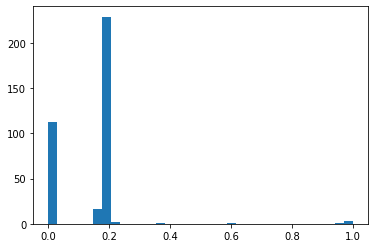

In [4]:
# extract RESPONSE column
response = mailout_train['RESPONSE']

# drop RESPONSE column
mailout_train.drop(labels=['RESPONSE'], axis=1, inplace=True)

# find features to drop because of many missing values
missing_per_column = mailout_train.isnull().mean()

plt.hist(missing_per_column, bins=34)

In [5]:
# read in feature info file
# feat_info = pd.read_csv('./feats_info.csv', sep=';', names=['feat', 'type', 'unknown'])
# feat_info.set_index('feat', inplace =True)

eda_mailout_train = eda.EDA(mailout_train, feat_info, label = 'mailout_train')

#  Data Cleaning
eda_mailout_train.data_pipeline()

Step 1: Delete undefined, multiple missing values and duplicate features ...
Before cleaning, Number of columns is 366 in mailout_train 
After cleaning, Number of columns is 300 in mailout_train 
Step 2: Convert missing and unknow values ...
Number of missing values in mailout_train:
Before converstion is 1955629
Ater converstion IS 2342602
Increase in missing values: 19.79 % 
Step 3: Delete the rows with more NaN values ...
Before cleaning, Number of rows is 300 in mailout_train 
After cleaning, Number of columns is 300 in mailout_train 
  8292 lines deleted!
Step 4: Re-encoding features...
   Re-encoding: OST_WEST_KZ ...
   Re-encoding: CAMEO_DEUG_2015 ...
   Re-encoding: CAMEO_INTL_2015 ...
Step 5: Split mixed features ...
   Spliting: CAMEO_INTL_2015 ...
   Spliting: LP_LEBENSPHASE_GROB ...
   Spliting: PRAEGENDE_JUGENDJAHRE ...
   Spliting: EINGEFUEGT_AM ...
Step 6: Handling outliers ...
Cleaning outliers for AGER_TYP  ...
Cleaning outliers for ALTERSKATEGORIE_GROB  ...
Cleaning o

Cleaning outliers for KBA13_KRSHERST_AUDI_VW  ...
Cleaning outliers for KBA13_KRSHERST_BMW_BENZ  ...
Cleaning outliers for KBA13_KRSHERST_FORD_OPEL  ...
Cleaning outliers for KBA13_KRSSEG_KLEIN  ...
Cleaning outliers for KBA13_KRSSEG_OBER  ...
Cleaning outliers for KBA13_KRSSEG_VAN  ...
Cleaning outliers for KBA13_KRSZUL_NEU  ...
Cleaning outliers for KBA13_KW_0_60  ...
Cleaning outliers for KBA13_KW_110  ...
Cleaning outliers for KBA13_KW_120  ...
Cleaning outliers for KBA13_KW_121  ...
Cleaning outliers for KBA13_KW_30  ...
Cleaning outliers for KBA13_KW_40  ...
Cleaning outliers for KBA13_KW_50  ...
Cleaning outliers for KBA13_KW_60  ...
Cleaning outliers for KBA13_KW_61_120  ...
Cleaning outliers for KBA13_KW_70  ...
Cleaning outliers for KBA13_KW_80  ...
Cleaning outliers for KBA13_KW_90  ...
Cleaning outliers for KBA13_MAZDA  ...
Cleaning outliers for KBA13_MERCEDES  ...
Cleaning outliers for KBA13_MOTOR  ...
Cleaning outliers for KBA13_NISSAN  ...
Cleaning outliers for KBA13_OPE

In [6]:
response = response.loc[mailout_train.index]
response.shape

(34670,)

### Preparing and splitting the data

In [7]:
# We split the dataset into 2/3 training and 1/3 testing sets.
train_data, test_data, train_targets, test_targets = train_test_split(
    eda_mailout_train.data_scaled, 
    response, 
    test_size=0.33, 
    shuffle=True,
    random_state=h.RANDOM_STATE)

### Step 4. model evaluation

In [8]:
lrm = LogisticRegression(random_state=h.RANDOM_STATE)
bagm = BaggingClassifier()
lgbm = lgb.LGBMClassifier(random_state=h.RANDOM_STATE,application='binary')

model_dict = {
    'logistic regression': lrm,    
    'bagging': bagm,
    'lgbmclassifier': lgbm,
}

h.build_roc_auc(model_dict, {},eda_mailout_train.data_scaled, response)    

Model: logistic regression,  Best ROC AUC score:  0.717432629811176
Model: bagging,  Best ROC AUC score:  0.558950952088307
Model: lgbmclassifier,  Best ROC AUC score:  0.7399174034502856


The LGBM classifier got a slightly better score so I'll use it down below to train and tuning for the kaggle competition. 

### Step 5. LGB Train and Hyperparameter Tuning

In [9]:
def_params={
        'learning_rate':  {'hpf' :  hp.loguniform('learning_rate', np.log(0.00001), np.log(0.0075)),'dtype' : 'float'},           
        'num_leaves' :    {'hpf' : hp.quniform('num_leaves', 3, 15, 1),'dtype' : 'int'},     
        'min_data_in_leaf' : {'hpf' : hp.quniform('min_data_in_leaf', 1000, 1500, 50),'dtype' : 'int'},     
        'min_sum_hessian_in_leaf':  {'hpf' : hp.uniform('min_sum_hessian_in_leaf', 0.0005, 0.002),'dtype' : 'float'},               
        'colsample_bytree': {'hpf': hp.uniform('colsample_bytree', 0.5, 0.9),'dtype' : 'float'},        
        'reg_alpha': {'hpf': hp.uniform('reg_alpha', 0.3, 1.0),'dtype' : 'float'}, 
        'reg_lambda': {'hpf': hp.uniform('reg_lambda', 0, 0.6),'dtype' : 'float'}, 
        'max_bin' :    {'hpf' : hp.quniform('max_bin', 10, 80, 1),'dtype' : 'int'},    
        'feature_fraction': {'hpf': hp.uniform('feature_fraction', 0.3, 0.7),'dtype' : 'float'},    
}

n_iter = 1000
cv = 10

best, trials, objective = t.search_hyperparameter(def_params, n_iter, cv ,train_data, train_targets)

model = t.build_model(best, def_params)

model.fit(train_data,train_targets)

t.evaluate_model(model, objective, best, test_data, test_targets)

sa_results_df = t.plot_result(trials.trials)

 34%|███████████████████████████████████████████████████████▋                                                                                                          | 344/1000 [11:27<21:50,  2.00s/trial, best loss: -0.7813870186822359]


KeyboardInterrupt: 

### Step 6. Top 15 most important features of the model

In [ ]:
lgb.plot_importance(model, max_num_features = 30, figsize=(10,12))

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
# mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')
mailout_test = pd.read_pickle ('..//data//mailout_test.p')    
mailout_test.shape

In [ ]:
eda_mailout_test = eda.EDA(mailout_test, feat_info, label = 'mailout_test')

In [ ]:
LNR = mailout_test.LNR.copy()
LNR.shape

In [ ]:
eda_mailout_test.data_pipeline(clean_rows = False)

In [ ]:
# fit and predict
preds_test = model.predict_proba(eda_mailout_test.data_scaled)[:,1]
preds_test

In [ ]:
# create submission file
preds_test = pd.concat([LNR, pd.Series(preds_test)], axis = 1)
preds_test.rename(columns={0:'RESPONSE'}, inplace= True)
preds_test.to_csv('MAILOUT_TEST.csv') 